In [8]:
!unzip -q Sentinel2_11_001 -d /Users/callu/Downloads/CoastTrain_dataset/Sentinel2_11_001


In [ ]:
!unzip -q UNET_training_data.zip -d /content/drive/MyDrive/CoastTrainOirthirSat/UNET_training_data

In [ ]:
!pip install patchify -q
!pip install segmentation_models -q

In [ ]:
!pip install google-colab


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

In [ ]:
# importing required packages
import glob
import numpy as np
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import models

In [ ]:
path = '/content/drive/MyDrive/CoastTrainOirthirSat/Landsat8_11_001/'
datasets = glob.glob(path+'*.npz')

In [ ]:
path = '/content/drive/MyDrive/CoastTrainOirthirSat/'
npz_files = glob.glob(path+'*/*.npz', recursive=True)
len(npz_files)

11

In [ ]:
np.savetxt(path+"all_npz_files.csv", npz_files, delimiter =", ", fmt ='% s')

In [ ]:
filtered_datasets = [file for file in npz_files if 'marsh_vegetation' not in load(file)['classes']]
len(filtered_datasets)
np.savetxt(path+"filtered_npz_files.csv", filtered_datasets, delimiter =", ", fmt ='% s')

In [ ]:
df = pd.read_csv(path+"filtered_npz_files.csv")
datasets = df.values.flatten().tolist()
datasets = [file for file in datasets if 'NAIP' not in file]
# datasets

In [ ]:
len(datasets)

10

In [ ]:
data = load(datasets[956])
# print(list(data))
print(data['image'].shape)
print(data['label'].shape)
print(list(data['classes']))

np.any(np.isnan(data['image']))

IndexError: ignored

data source: UNET_training_data
img shape : (256, 256, 3)
label shape : (256, 256, 3)
classes : ['water' 'land' 'nodata']


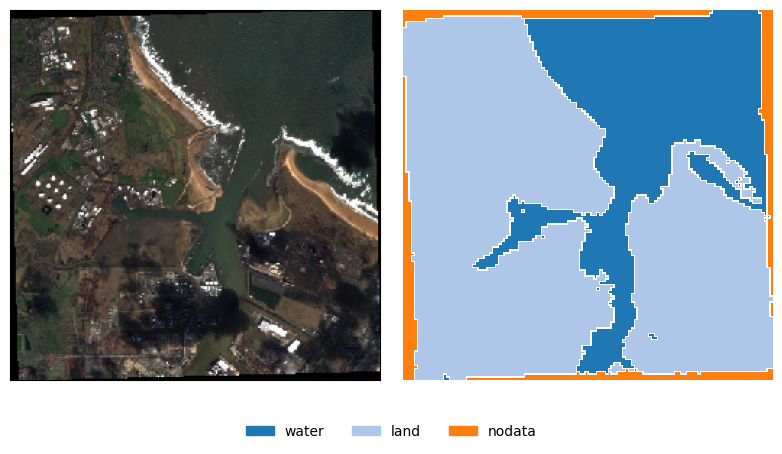

In [ ]:
#@title Sanity Check
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import math
import matplotlib.patches as mpatches
import random

random_number = random.randint(0, len(datasets))
# random_number = 342
ds = load(datasets[random_number])
print('data source:',datasets[random_number].split('/')[-2])
# ds = load('/content/drive/MyDrive/CoastTrain_dataset/Landsat8_11_001/ventura_2019-10-05-18-28-42_L8_rgb_ID2.npz')
image = ds['image']
mask = ds['label']
classes = ds['classes']

fig, ax = plt.subplots(1, 2, figsize=(8,4))
plt.box(on=None)
plt.setp(ax, xticks=[], yticks=[])

ax[0].imshow(image)
print('img shape :', image.shape)
label = mask.astype('float')
print('label shape :', label.shape)
label[label == 0] = np.nan
print('classes :', classes)

palette_tab20 = sns.color_palette('tab20', 11)

for i in range(label.shape[2]):
    new_colormap = ListedColormap(sns.color_palette([palette_tab20[i]]))
    ax[1].imshow(label[:, :, i], cmap=new_colormap)

# # create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=palette_tab20[i],label=classes[i]) for i in range(label.shape[2])]

# put those patched as legend-handles into the legend
fig.legend(handles=patches, loc='lower center', ncols=3, bbox_to_anchor=(0.5,-0.14), frameon=False)

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/temp/categories_plot.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

Import training and testing data as tf.data

In [ ]:
#@title Trial:reduce the category
# def pad_up_to(t, max_in_dims, constant_values):
#     s = tf.shape(t)
#     padding = [[0,0],[0,0],[0, max_in_dims-s[2]]]
#     return tf.pad(t,padding,'CONSTANT',constant_values=constant_values)

# def get_data_from_filename(filename):
#    npdata = load(filename)
#    img = npdata['image'][:, :, :3] # some images have 4 channels (nir band)
#    image = tf.image.resize_with_crop_or_pad(img, 256, 256)
#    label2normal = np.argmax(npdata['label'],axis=-1)
#    label2normal[]


#    label = tf.image.resize_with_crop_or_pad(tf.one_hot(label2normal, ), 256, 256)
#    label = pad_up_to(label,11,0)
#    return image, label

# def get_data_wrapper(filename):
#    img, label = tf.numpy_function(
#        get_data_from_filename, [filename], (tf.uint8, tf.uint8))
#    return img, label

In [ ]:
def pad_up_to(t, max_in_dims, constant_values):
    s = tf.shape(t)
    padding = [[0,0],[0,0],[0, max_in_dims-s[2]]]
    return tf.pad(t,padding,'CONSTANT',constant_values=constant_values)

def get_data_from_filename(filename):
   npdata = load(filename)
   img = npdata['image'][:, :, :3] # some images have 4 channels (nir band)
   image = tf.image.resize_with_crop_or_pad(img, 256, 256)
   label = tf.image.resize_with_crop_or_pad(npdata['label'], 256, 256)
   label = pad_up_to(label,11,0)
   return image, label

def get_data_wrapper(filename):
   img, label = tf.numpy_function(
       get_data_from_filename, [filename], (tf.uint8, tf.uint8))
   return img, label

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(datasets).map(get_data_wrapper)
# Specify seed to always have the same split distribution between runs
ds = ds.shuffle(160, seed=10)

In [ ]:
img, la = next(iter(ds.take(100)))
print(img.shape, la.shape)

(256, 256, 3) (256, 256, 11)


In [ ]:
ds_size = tf.data.experimental.cardinality(ds).numpy()

# split data for the training and validation in the ratio of 4:1
train_size = int(0.8 * ds_size)
print('train_size:',train_size)

val_size = ds_size - train_size
print('val_size:',val_size)

train_size: 604
val_size: 152


In [ ]:
train_ds_part = ds.take(train_size)
val_ds_part = ds.skip(train_size).take(val_size)

Modelling

In [ ]:
batch_size = 40

train_ds = train_ds_part.shuffle(40).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_part.batch(batch_size)

In [ ]:
# using weights from pretained resnet model.
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# add bakcend, models, layers, utils submodules in kwargs
# preprocess input.
train_ds_prepr = preprocess_input(train_ds)
val_ds_prepr = preprocess_input(val_ds)

In [ ]:
n_classes = 11

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [ ]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem.
metrics = ['categorical_accuracy']
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
model.summary()

In [ ]:
# epochs = 20
# checkpoint_filepath = '/content/drive/MyDrive/trained_model/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_categorical_accuracy',
#     mode='max',
#     save_best_only=True)
# history = model.fit(train_ds,epochs=epochs,
#                     callbacks=[model_checkpoint_callback],
#                     verbose=1,
#                     validation_data=val_ds)

In [ ]:
num_train = train_size
epochs = 20
history = model.fit(train_ds_prepr,
        # steps_per_epoch= int(np.ceil(num_train / float(batch_size))),
          epochs=epochs,
          verbose=1,
          validation_data=val_ds_prepr)

Epoch 1/20
15/15 [==============================] - 107s 5s/step - loss: 1.2349 - categorical_accuracy: 0.4242 - val_loss: 8.2815 - val_categorical_accuracy: 0.1530
Epoch 2/20
15/15 [==============================] - 51s 3s/step - loss: 0.9150 - categorical_accuracy: 0.4953 - val_loss: 8.4527 - val_categorical_accuracy: 0.1511
Epoch 3/20
15/15 [==============================] - 45s 3s/step - loss: 0.8356 - categorical_accuracy: 0.5666 - val_loss: 8.6449 - val_categorical_accuracy: 0.1445
Epoch 4/20
15/15 [==============================] - 46s 3s/step - loss: 0.7807 - categorical_accuracy: 0.5610 - val_loss: 9.1438 - val_categorical_accuracy: 0.0866
Epoch 5/20
15/15 [==============================] - 45s 3s/step - loss: 0.7379 - categorical_accuracy: 0.6174 - val_loss: 5.7776 - val_categorical_accuracy: 0.4689
Epoch 6/20
15/15 [==============================] - 46s 3s/step - loss: 0.6848 - categorical_accuracy: 0.5894 - val_loss: 2.9453 - val_categorical_accuracy: 0.2126
Epoch 7/20
15/1

In [ ]:
model.save('/content/drive/MyDrive/trained_model/unet_resnet50.keras')

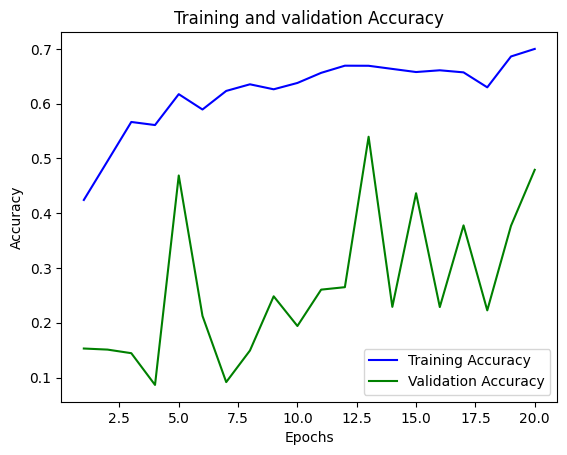

In [ ]:
# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'blue', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'green', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/temp/accuracy.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
#@title Mapdisplay: Display ee.Features and ee.Images using folium.
import folium
# print('Folium version: ' + folium.__version__)

# Define the URL format used for Earth Engine
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = EE_TILES.format(**v),
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [ ]:
#@title The coordinates of some sites in the UK for test
sites_list = [
           [-3.11,54.959], #Carlisle
            [-3.198,54.088], #Barrow_in_Furness
            [-1.845,55.658], #Fenham
            [-3.078,56.44], #Dundee
            [-3.143,53.287], #River_Dee
            [-4.548,55.929], #River_Clyde
            [0.202,52.875], #River_Great_Ouse
            [0.725,50.911], #Winchelsea
            [-4.059,52.533], #Aberdyfi
            [-4.423,51.742], #St_Ishmael
            [-3.85,51.615], #Swansea
            [-6.959,55.191], #Magilligan_Point
            [-5.44,54.458], #Portavogie
            [-1.83,57.5812], #St_Fergus
            [-4.253,58.525], #Torrisdale
            [-3.73,57.64], #Wellhill
            [-1.167,54.635], #Coatham
            [1.732,52.432], #Kessingland
            [1.371,51.385], #Margate
            [-4.82,52.054], #Tredrissi
]

sites_name = ['Carlisle','Barrow_in_Furness','Fenham','Dundee','River_Dee','River_Clyde',
'River_Great_Ouse','Winchelsea','Aberdyfi','St_Ishmael','Swansea','Magilligan_Point',
'Portavogie','St_Fergus','Torrisdale','Wellhill','Coatham','Kessingland','Margate','Tredrissi']

In [ ]:
#@title apply scale factors to Landsat Collection 2 dataset
def applyScaleFactors(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0);
  return image.addBands(opticalBands, None, True)\
              .addBands(thermalBands, None, True)

In [ ]:
!pip install retry -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
import requests
import shutil
from retry import retry
import ee
import logging
import multiprocessing

In [ ]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=LxyVxiDFN_mtzsgzloHs5gUi97MnkmGEKpGPSsqLhG4&tc=tfIklboPVElwyhOLbFapRtCH0Vbiz5FwhZezlOxJra8&cc=qTq92TPDh5ojqQ8b_5nvNtUzak12B1mFahDvD2AfOCY

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXmwGPUXIDBvxqgu0M32giEhACzeYLkiXhmNKjmJh97IualD19EOEVo

Successfully saved authorization token.


In [ ]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
logging.basicConfig()

In [ ]:
#@title Download image patches in .npy or .jpg format

# Calculate clarity scores for each image
def clarity_check(img,geometry):
  qa = img.select('QA_PIXEL')

  cloudShadowBitMask = 1 << 4
  snowBitMask = 1 << 5
  clearBitMask = 1 << 6

  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0)\
              .And(qa.bitwiseAnd(snowBitMask).eq(0))\
              .And(qa.bitwiseAnd(clearBitMask).neq(0))

  total_pixel_count = img.reduceRegion(reducer=ee.Reducer.count(), geometry=geometry,
                                       maxPixels=1e13,scale=30)
  clear_pixel_count = img.updateMask(mask).reduceRegion(reducer=ee.Reducer.count(), geometry=geometry,
                                       maxPixels=1e13,scale=30)

  clarity_score = ee.Number(clear_pixel_count.values(['QA_PIXEL']).get(0))\
                    .divide(total_pixel_count.values(['QA_PIXEL']).get(0)).multiply(ee.Number(100))

  return img.set({'clarity_score':clarity_score})

@retry(tries=10, delay=1, backoff=2)
def get_result(index, point):
    img_col = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
    selectors = ['SR_B4','SR_B3','SR_B2']
    bbox = ee.Geometry.Point(point).buffer(127*30).bounds()
    imgs_filter_list = img_col.filterDate('2022-01-01', '2022-09-01')\
                                .filterBounds(bbox)\
                                .map(lambda img: clarity_check(img,bbox))\
                                .filter(ee.Filter.gte('clarity_score',80))\
                                .reduceColumns(ee.Reducer.toList(), ['system:index']).get('list')

    for imgID in imgs_filter_list.getInfo():
        img = ee.Image('LANDSAT/LC09/C02/T1_L2/'+imgID).select(selectors).multiply(0.0000275).add(-0.2)
        img_c = img.clip(bbox).visualize(bands=selectors, min=0, max=0.25)
        # url = img_c.getDownloadURL({'region':bbox, 'dimensions': '256x256', 'format': 'NPY'})
        url = img_c.getThumbURL({'region':bbox, 'dimensions': '256x256', 'format': 'jpg'})


        # handle downloading the actual pixels
        r = requests.get(url, stream=True)
        if r.status_code != 200:
            r.raise_for_status()
        filename = '%s_%s.jpg' % (imgID,sites_name[index])
        with open('/content/drive/MyDrive/Landsat9_UK_coast_jpg/'+filename, 'wb') as out_file:
            shutil.copyfileobj(r.raw, out_file)
        # print('\n Done:', index)

pool = multiprocessing.Pool(25)
pool.starmap(get_result, enumerate(sites_list))
pool.close()
pool.join()

In [ ]:
#@title Download Sentinel-2 image patches in .jpg format

# Calculate clarity scores for each image
def clarity_check(img,geometry):
#   qa = img.select('QA60')

#   cloudBitMask = 1 << 10
#   cirrusBitMask = 1 << 11


#   mask = (qa.bitwiseAnd(cloudBitMask).eq(0)
#         .And(qa.bitwiseAnd(cirrusBitMask).eq(0)))
  scl = img.select('SCL')
  mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6))#.Or(scl.eq(11))


  total_pixel_count = img.reduceRegion(reducer=ee.Reducer.count(), geometry=geometry,
                                       maxPixels=1e13,scale=30)
  clear_pixel_count = img.updateMask(mask).reduceRegion(reducer=ee.Reducer.count(), geometry=geometry,
                                       maxPixels=1e13,scale=30)

  clarity_score = (ee.Number(clear_pixel_count.values(['B2']).get(0))
            .divide(total_pixel_count.values(['B2']).get(0)).multiply(ee.Number(100)))
  validity = ee.Number(total_pixel_count.values(['B2']).get(0)).divide(ee.Number(64516)).multiply(ee.Number(100))

  return img.set({'valid_coverage':validity,'clarity_score':clarity_score})

@retry(tries=10, delay=1, backoff=2)
def get_result(index, point):
    img_col = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    selectors = ['B4','B3','B2']
    bbox = ee.Geometry.Point(point).buffer(127*30).bounds()
    imgs_filter_list = (img_col.filterDate('2023-01-01', '2023-08-01')
                                .filterBounds(bbox)
                                .map(lambda img: clarity_check(img,bbox))
                                # .filter(ee.Filter.gte('clarity_score',90))\
                                .filter(ee.Filter.lte('clarity_score',50))
                                .filter(ee.Filter.gte('valid_coverage',80))
                                .reduceColumns(ee.Reducer.toList(), ['system:index']).get('list'))

    for imgID in imgs_filter_list.getInfo():
        img = ee.Image('COPERNICUS/S2_SR_HARMONIZED/'+imgID).select(selectors).multiply(0.0001)
        img_c = img.clip(bbox).visualize(bands=selectors, min=0, max=0.3)
        url = img_c.getThumbURL({'region':bbox, 'dimensions': '256x256', 'format': 'jpg'})


        # handle downloading the actual pixels
        r = requests.get(url, stream=True)
        if r.status_code != 200:
            r.raise_for_status()
        filename = '%s_%s.jpg' % (imgID,sites_name[index])
        with open('/content/drive/MyDrive/sen2_cloudy_images/'+filename, 'wb') as out_file:
            shutil.copyfileobj(r.raw, out_file)
        # print('\n Done:', index)

pool = multiprocessing.Pool(25)
pool.starmap(get_result, enumerate(sites_list))
pool.close()
pool.join()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# structured array converted to normal array
img = np.load('/content/drive/MyDrive/Landsat9_UK_coast/LC09_200024_20220812_Kessingland.npy')
img = img.view(np.uint8).reshape(img.shape+(-1,))
print(img.shape)

In [ ]:
plt.imshow(img)

In [ ]:
prec_path = '/content/drive/MyDrive/Landsat9_UK_coast/'
landsat9_ds = glob.glob(prec_path+'*.npy')

In [ ]:
def get_normal_3Darray(filename):
   npdata = np.load(filename)
   img = npdata.view(np.uint8).reshape(npdata.shape+(-1,))
   return img

def get_tfdata(filename):
   img = tf.numpy_function(
       get_normal_3Darray, [filename], tf.uint8)
   return img

In [ ]:
pred_ds = tf.data.Dataset.from_tensor_slices(landsat9_ds).map(get_tfdata).batch(1)

In [ ]:
# model.load_weights(checkpoint_filepath)

In [ ]:
model = load_model('/content/drive/MyDrive/trained_model/unet_resnet50.keras')

In [ ]:
predictions = model.predict(pred_ds)

139/139 [==============================] - 3s 16ms/step


In [ ]:
print(predictions)

In [ ]:
import sys

# np.set_printoptions(threshold=sys.maxsize)
np.argmax(list(predictions)[0], axis=2)

In [ ]:
#@title visualization RGB color for land cover
palette = np.array([[0, 0, 255],     #0 blue water
                    [0, 255, 255],   #1 aqua whitewater
                    [218, 165, 32],  #2 golden_rod sediment
                    [139,69,19],     #3 brown  other natural terrain
                    [0, 100, 0],     #4 dark_green vegetated surface
                    [0, 255, 0],     #5 lime agricultural
                    [255, 127, 80],  #6 coral development
                    [255, 255, 255], #7 white cloud
                    [0, 0, 0],       #8 black nodata
                    [112, 128, 144], #9 gray unusual
                    [128, 0, 128]])  #10 purple unknown

In [ ]:
#@title visualize the predictions
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20c.colors)
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

for filename, prediction in zip(landsat9_ds, predictions): # using zip to iterate simultaneously
    print(filename)
    labels = ['water','whitewater','sediment','other_natural_terrain',
            'vegetated_surface','agricultural','development','cloud','nodata',
            'unusual','unknown']

    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    plt.box(on=None)
    plt.setp(ax, xticks=[], yticks=[])

    img = get_normal_3Darray(filename)
    ax[0].imshow(img)

    max_prob = np.argmax(prediction, axis=2)
    cmap = plt.get_cmap('tab20')
    rgb_values = ListedColormap(cmap(np.arange(cmap.N))).colors[:,:3]
    rgb_values[8] = [0, 0, 0] # black color -> no data
    rgb_values[9] = [0, 0, 0] # black color -> unusual
    rgb_values[10] = [0, 0, 0] # black color -> unknown
    rgb_img = rgb_values[max_prob]
    ax[1].imshow(rgb_img)

    # # create a patch (proxy artist) for every color
    patches = [mpatches.Patch(color=rgb_values[i],label=labels[i]) for i in range(len(labels))]

    # put those patched as legend-handles into the legend
    fig.legend(handles=patches, loc='right', ncols=1, bbox_to_anchor=(1.33,0.45), frameon=False)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/temp/results.eps', format='eps', dpi=300, bbox_inches='tight')
    plt.show()